In [2]:
%matplotlib widget
import os, re
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
import copy

import lightly
from lightly.data import LightlyDataset
from lightly.data import ImageCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.loss import BarlowTwinsLoss

from lightly.data import DINOCollateFunction
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum

from avalanche.models import SimpleCNN

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import pandas as pd
from PIL import Image
import cv2
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import datasets
from datasets.wrgbd import WRGBD
from datasets.coil100 import Coil100Dataset
from avalanche.benchmarks.datasets import CORe50Dataset
import importlib

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
root_dir = '/home/ehajizad/ss_learning/neuromorphic-continual-learning'
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
importlib.reload(datasets.wrgbd)
from datasets.wrgbd import WRGBD

from torchvision.transforms.functional import pad
class SquarePad:
    def __call__(self,image):
        w, h = image.size
        # max_wh=200
        max_wh = np.max([w, h])
        h_padding = int((max_wh - w) / 2)
        v_padding = int((max_wh - h) / 2)
        l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
        t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
        r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
        b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5

        padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
        return pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'
dataset = WRGBD(root_dir = dataset_dir, transform=transform, read_target_lists=False, all_data=True)
n_obj_per_cat = np.array(dataset.n_obj_per_cat)

# dataset.write_target_lists_to_file()

6 object are loaded
11 object are loaded
16 object are loaded
23 object are loaded
31 object are loaded
35 object are loaded
40 object are loaded
44 object are loaded
47 object are loaded
51 object are loaded
57 object are loaded
69 object are loaded
74 object are loaded
79 object are loaded
84 object are loaded
87 object are loaded
91 object are loaded
98 object are loaded
104 object are loaded
110 object are loaded
113 object are loaded
119 object are loaded
127 object are loaded
130 object are loaded
134 object are loaded
140 object are loaded
154 object are loaded
159 object are loaded
163 object are loaded
168 object are loaded
177 object are loaded
185 object are loaded
189 object are loaded
195 object are loaded
198 object are loaded
203 object are loaded
209 object are loaded
217 object are loaded
222 object are loaded
228 object are loaded
233 object are loaded
237 object are loaded
241 object are loaded
247 object are loaded
254 object are loaded
266 object are loaded
275 obj

In [26]:
def show_batch(dl, batch_size=12):
    nrow=12
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=nrow, ncol=int(batch_size/nrow)).permute(1, 2, 0))
        plt.tight_layout()
        break


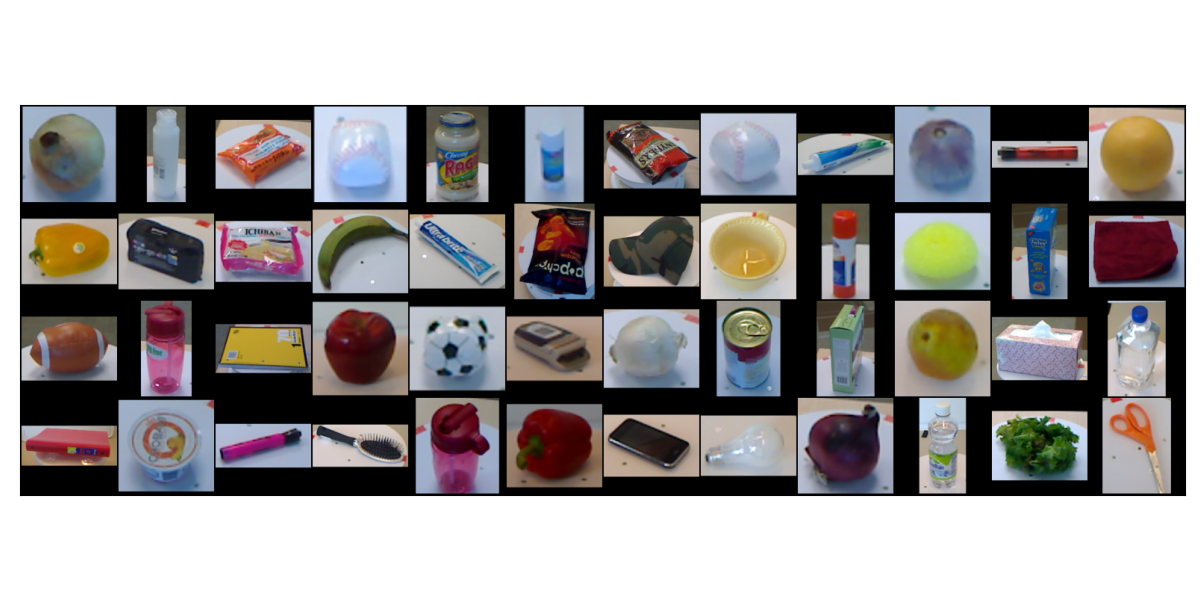

In [71]:
from torch.utils.data import Dataset, DataLoader, random_split
batch_size = 48
feat_ext_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
show_batch(feat_ext_dl)

In [7]:
resnet = lightly.models.ResNetGenerator('resnet-9')
feat_ext = nn.Sequential(*list(resnet.children())[:-1],nn.AdaptiveAvgPool2d(1))

feat_ext = feat_ext.to(device)

In [14]:
# model_name = "core50_simsiam_resnet9"
# #core50_simclr_resnet9_future_50_full_data

# feat_ext.load_state_dict(torch.load(
#         root_dir+"/models/"+model_name+".pth",
#         map_location=device))

vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_FEATURES')
feat_ext = vgg16.to(device)
feat_ext.eval()
print("Model loeaded")

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /home/ehajizad/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Model loeaded


In [17]:
from torchvision import models
from torchinfo import summary
conv_feat_ext = feat_ext.features
# conv_feat_ext = feat_ext
conv_feat_ext.eval()
summary(conv_feat_ext, (1,3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 4, 4]            --
├─Conv2d: 1-1                            [1, 64, 128, 128]         1,792
├─ReLU: 1-2                              [1, 64, 128, 128]         --
├─Conv2d: 1-3                            [1, 64, 128, 128]         36,928
├─ReLU: 1-4                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-5                         [1, 64, 64, 64]           --
├─Conv2d: 1-6                            [1, 128, 64, 64]          73,856
├─ReLU: 1-7                              [1, 128, 64, 64]          --
├─Conv2d: 1-8                            [1, 128, 64, 64]          147,584
├─ReLU: 1-9                              [1, 128, 64, 64]          --
├─MaxPool2d: 1-10                        [1, 128, 32, 32]          --
├─Conv2d: 1-11                           [1, 256, 32, 32]          295,168
├─ReLU: 1-12                             [1, 256, 32, 32]       

In [18]:
embeddings = []
labels = []

dataset_dir = '/home/ehajizad/datasets/rgbd-dataset'
dataset = WRGBD(root_dir = dataset_dir, transform=transform, read_target_lists=True, obj_level=True, all_data=True)
all_obj_labels = dataset.obj_targets
all_cat_labels = dataset.cat_targets
all_view_targets = dataset.view_targets

ss_inds = list(range(0,len(dataset.targets),5))
dataset = torch.utils.data.Subset(dataset, ss_inds)

feat_ext_dl = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

conv_feat_ext.eval()
with torch.no_grad():
    for batch in feat_ext_dl:
        image, label = batch 
        # print("Before data:", torch.cuda.memory_allocated(device)/1e9)
        image, label = image.to(device), label.to(device)
        emb = conv_feat_ext(image).flatten(start_dim=1)
        embeddings.append(emb)
        labels.append(label)
        
embeddings = torch.cat(embeddings, 0)
embeddings = np.array(torch.Tensor.cpu(embeddings))

labels = torch.cat(labels)
labels = np.array(torch.Tensor.cpu(labels))

All target lists are loaded


In [19]:
ss_obj_labels = np.array(all_obj_labels)[ss_inds]
ss_cat_labels = np.array(all_cat_labels)[ss_inds]
ss_view_targets = np.array(all_view_targets)[ss_inds]

In [20]:
embeddings.shape

(41584, 2048)

In [38]:
41584/51

815.3725490196078

In [185]:
sorted_inds = np.argsort(labels)

y_sorted = labels[sorted_inds]
x_sorted = embeddings[sorted_inds]

In [186]:
y = y_sorted.copy()
X = x_sorted.copy()

In [187]:
unique, counts = np.unique(labels, return_counts=True)
np.mean(counts)

140.48648648648648

In [39]:

X_tsne = TSNE(n_components=2, learning_rate='auto', n_jobs=-1, n_iter_without_progress=100, verbose=2,
                 init='pca', perplexity=600, n_iter=2500, metric='cosine').fit_transform(X)

[t-SNE] Computing 1801 nearest neighbors...
[t-SNE] Indexed 41584 samples in 0.062s...
[t-SNE] Computed neighbors for 41584 samples in 59.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41584
[t-SNE] Computed conditional probabilities for sample 2000 / 41584
[t-SNE] Computed conditional probabilities for sample 3000 / 41584
[t-SNE] Computed conditional probabilities for sample 4000 / 41584
[t-SNE] Computed conditional probabilities for sample 5000 / 41584
[t-SNE] Computed conditional probabilities for sample 6000 / 41584
[t-SNE] Computed conditional probabilities for sample 7000 / 41584
[t-SNE] Computed conditional probabilities for sample 8000 / 41584
[t-SNE] Computed conditional probabilities for sample 9000 / 41584
[t-SNE] Computed conditional probabilities for sample 10000 / 41584
[t-SNE] Computed conditional probabilities for sample 11000 / 41584
[t-SNE] Computed conditional probabilities for sample 12000 / 41584
[t-SNE] Computed conditional probabilities for 

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 62.8726959, gradient norm = 0.0041486 (50 iterations in 25.766s)
[t-SNE] Iteration 100: error = 65.6882782, gradient norm = 0.0006447 (50 iterations in 27.542s)
[t-SNE] Iteration 150: error = 65.6810913, gradient norm = 0.0006202 (50 iterations in 26.788s)
[t-SNE] Iteration 200: error = 65.6681519, gradient norm = 0.0006607 (50 iterations in 26.819s)
[t-SNE] Iteration 250: error = 65.6735077, gradient norm = 0.0007345 (50 iterations in 25.550s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.673508
[t-SNE] Iteration 300: error = 1.8472412, gradient norm = 0.0005572 (50 iterations in 24.510s)
[t-SNE] Iteration 350: error = 1.5166960, gradient norm = 0.0002281 (50 iterations in 23.990s)
[t-SNE] Iteration 400: error = 1.3758230, gradient norm = 0.0001259 (50 iterations in 23.826s)
[t-SNE] Iteration 450: error = 1.3018667, gradient norm = 0.0000830 (50 iterations in 23.973s)
[t-SNE] Iteration 500: error = 1.2569857, gradient norm = 0.000

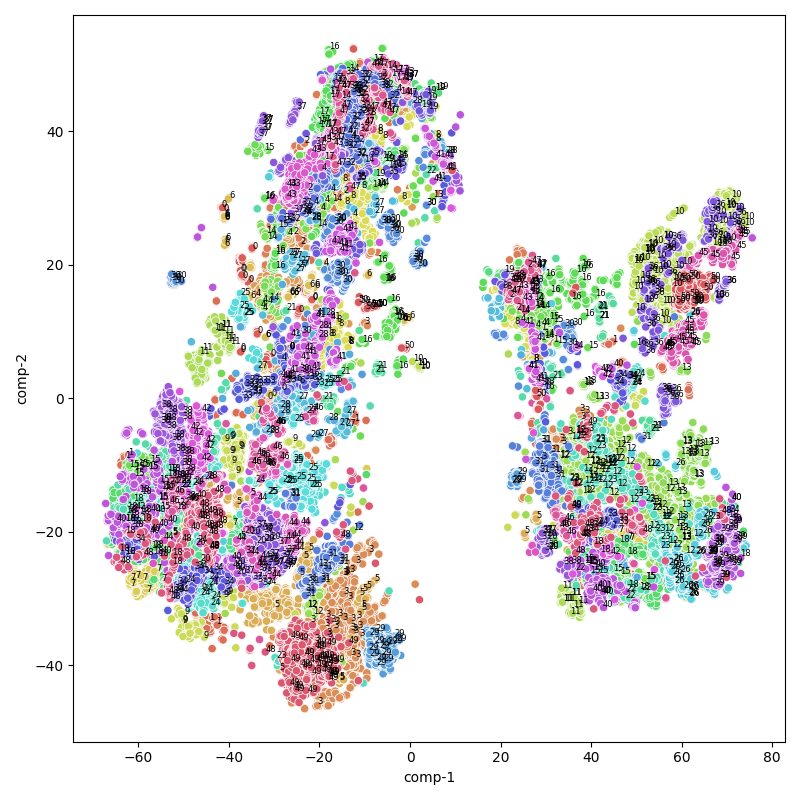

In [40]:
import seaborn as sns
y = ss_cat_labels.copy()
n_objects = len(np.unique(y))
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]

# n_objs_to_plot = 20
# df.loc[df["y"] >=n_objs_to_plot, "y"] = 0

n_colors = len(np.unique(df["y"] ))
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_colors),legend=False,
                data=df)

a = pd.concat({'x': df["comp-1"], 'y': df["comp-2"], 'label': df["y"]}, axis=1)
a = a.sample(frac=0.03, replace=True, random_state=1)
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['label'].astype(int)), fontsize=6)
    
plt.tight_layout()

In [67]:
###----------------------------------------------------------###
###-----Offline Object Categorization Exepriment-------------###

X = embeddings.copy()
y = ss_cat_labels.copy()

# Leave one instance from each category for testing, in the categorization experiments

# Choose single object instance from each category as test instance
cum_obj_count = [0] + np.cumsum(n_obj_per_cat).tolist()

accs = []
for t in range(3):
    test_obj_ind = []
    for i in range(len(n_obj_per_cat)):
        test_obj_ind.append(np.random.choice(np.arange(cum_obj_count[i], cum_obj_count[i+1])))

    test_inds = np.where(np.isin(ss_obj_labels,test_obj_ind))[0]
    train_inds = np.delete(np.arange(len(y)), test_inds)

    X_train = X[train_inds,:]
    X_test = X[test_inds,:]
    y_train = y[train_inds]
    y_test = y[test_inds]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test

    # clf = svm.LinearSVC(max_iter=2000)
    clf = make_pipeline(svm.SVC(kernel='linear', max_iter=1000))
    # clf = svm.LinearSVC(max_iter=10000)
    clf.fit(X_train, y_train)

    # y_pred_train=clf.predict(X_train)
    y_pred_test=clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    # print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
    acc = metrics.accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", acc)
    accs.append(acc)

/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.7413744343891403


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.7816256439610761


/home/ehajizad/ss_learning/ssl_env/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.7701047661207023


In [68]:
mean_acc = np.round(100*np.mean(accs),1)
std_acc = np.round(100*np.std(accs),1)
print("Offline Object Categorization Exepriment accuracies:", str(mean_acc), u"\u00B1", str(std_acc))


Offline Object Categorization Exepriment accuracies: 76.4 ± 1.7


In [34]:
###----------------------------------------------------------###
###-----Offline Object Identifiation Exepriment--------------###

X = embeddings.copy()
y = ss_obj_labels.copy()

# Leave one (elevation) viewing angle out of three (30, 45, 60) in the object identification experiments

test_inds = np.where(ss_view_targets==2)[0]
train_inds = np.delete(np.arange(len(y)), test_inds)

X_train = X[train_inds,:]
X_test = X[test_inds,:]
y_train = y[train_inds]
y_test = y[test_inds]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, shuffle=True) # 80% training and 20% test


clf = make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', max_iter=1000))
# clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
acc = metrics.accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", acc)


KeyboardInterrupt: 

In [51]:
print("Test Accuracy:", acc)

Test Accuracy: 0.7348736462093863


In [27]:
n_obj_per_cat

array([ 6,  5,  5,  7,  8,  4,  5,  4,  3,  4,  6, 12,  5,  5,  5,  3,  4,
        7,  6,  6,  3,  6,  8,  3,  4,  6, 14,  5,  4,  5,  9,  8,  4,  6,
        3,  5,  6,  8,  5,  6,  5,  4,  4,  6,  7, 12,  9,  8,  5,  6,  6])

In [32]:
from sklearn.utils import shuffle
n_repeat = 4
bmu_metrics = ["euclidean", "dot_product", "cosine"]
accs = np.zeros(shape=(len(bmu_metrics),n_repeat))
n_neighbors = 1

X = embeddings.copy()
y = ss_cat_labels.copy()
# y = ss_obj_labels.copy()

# Leave one instance from each category for testing, in the categorization experiments
# Choose single object instance from each category as test instance
cum_obj_count = [0] + np.cumsum(n_obj_per_cat).tolist()


for bm, bmu_metric in enumerate(bmu_metrics): 
    for r in range(n_repeat):
        
        test_obj_ind = []
        for i in range(len(n_obj_per_cat)):
            test_obj_ind.append(np.random.choice(np.arange(cum_obj_count[i], cum_obj_count[i+1])))

        test_inds = np.where(np.isin(ss_obj_labels,test_obj_ind))[0]
        train_inds = np.delete(np.arange(len(y)), test_inds)
        
        # Leave one (elevation) viewing angle out of three (30, 45, 60) in the object identification experiments

        # test_inds = np.where(ss_view_targets==2)[0]
        # train_inds = np.delete(np.arange(len(y)), test_inds)

        X_train = X[train_inds,:]
        X_test = X[test_inds,:]
        y_train = y[train_inds]
        y_test = y[test_inds]
        
        if bmu_metric != "dot_product":
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=bmu_metric)
            knn.fit(X_train, y_train)
            y_pred_test=knn.predict(X_test)
            
        else:
            sim_X_train = np.matmul(X_train,X_train.T)
            sim_X_test = np.matmul(X_test,X_train.T)

#             sim_X_train[sim_X_train<dp_min] = dp_min
#             sim_X_train[sim_X_train>dp_max] = dp_max

#             sim_X_test[sim_X_test<dp_min] = dp_min
#             sim_X_test[sim_X_test>dp_max] = dp_max

            sim_X_train = np.max(sim_X_train) - sim_X_train
            sim_X_test = np.max(sim_X_test) - sim_X_test
            
            knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute",  metric="precomputed")
            knn.fit(sim_X_train, y_train)

            y_pred_test=knn.predict(sim_X_test)

        # Model Accuracy: how often is the classifier correct?
        acc = metrics.accuracy_score(y_test, y_pred_test)        
        accs[bm, r] = acc

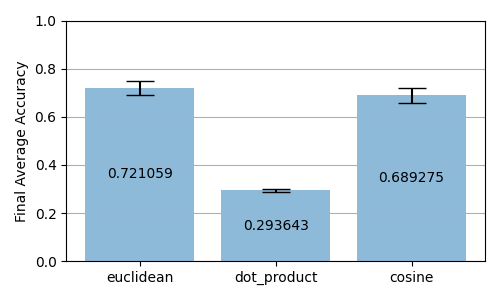

In [33]:
x_pos = np.arange(len(bmu_metrics))
CTEs = np.mean(accs, axis=1)
error = np.std(accs, axis=1)

# Build the plot
fig, ax = plt.subplots(figsize=(5,3))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Final Average Accuracy')
ax.set_xticks(x_pos)
ax.set_xticklabels(bmu_metrics)
ax.yaxis.grid(True)
ax.set_ylim([0,1])
ax.bar_label(bars, label_type='center')


# Save the figure and show
plt.tight_layout()
plt.show()
# print(CTEs)

In [35]:
clf = svm.LinearSVC(max_iter=2000)
# clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

# y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)

# Model Accuracy: how often is the classifier correct?
# print("Train Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_test))

Test Accuracy: 0.7881673881673882


In [160]:
nn = np.arange(1,20,2)
accs_cos = []
accs_euc = []
for i in nn:
    knn = KNeighborsClassifier(n_neighbors=i, metric="cosine")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_cos.append(acc)
    
    knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
    knn.fit(X_train, y_train)

    y_pred_test=knn.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    acc = metrics.accuracy_score(y_test, y_pred_test)
    accs_euc.append(acc)
    # print("Test Accuracy:", acc)

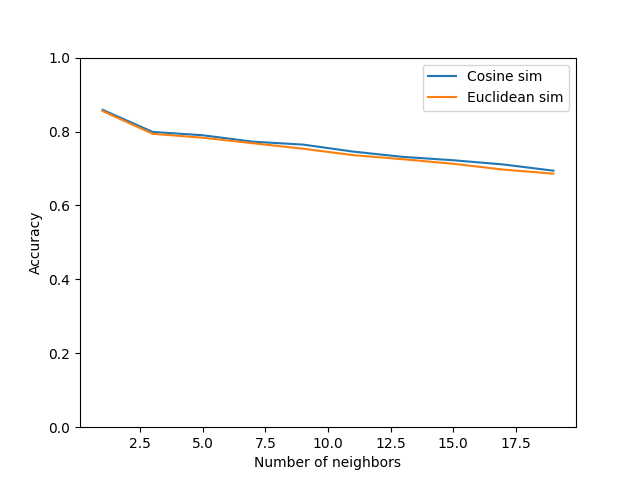

In [161]:
plt.figure()
plt.plot(nn, accs_cos)
plt.plot(nn, accs_euc)
plt.legend(["Cosine sim", "Euclidean sim"])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.ylim([0,1])

plt.show()